In [1]:
from matplotlib import pyplot
from math import pi
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
import numba
from numba import jit

In [2]:
def Fc1(u,v,dx,dy):
    F=numpy.zeros(numpy.shape(u))
    F[1:-1,1:-1]=-((u[1:-1,1:-1]+u[1:-1,2:])**2-(u[1:-1,1:-1]+u[1:-1,:-2])**2)/(4*dx)-\
                  ((u[1:-1,1:-1]+u[2:,1:-1])*(v[1:-1,2:]+v[1:-1,1:-1])-\
                  (u[1:-1,1:-1]+u[:-2,1:-1])*(v[:-2,2:]+v[:-2,1:-1]))/(4*dy)
        
    F[:,0]=-F[:,1]
    F[:,-1]=-F[:,-2]
    F[0,:]=-F[1,:]
    F[-1,:]=-F[-2,:]
    return F

In [3]:
def Fv1(u,v,dx,dy):
    F=numpy.zeros(numpy.shape(u))
    F[1:-1,1:-1]=((u[1:-1,2:]-2*u[1:-1,1:-1]+u[1:-1,:-2])/dx**2+\
                 (u[2:,1:-1]-2*u[1:-1,1:-1]+u[:-2,1:-1])/dy**2)/100
    
    F[:,0]=-F[:,1]
    F[:,-1]=-F[:,-2]
    F[0,:]=-F[1,:]
    F[-1,:]=-F[-2,:]
    return F

In [4]:
def Fp1(p,dx,dy):
    F=numpy.zeros(numpy.shape(p))
    F[1:-1,1:-1]=-(p[1:-1,2:]-p[1:-1,1:-1])/dx/100
    F[:,0]=-F[:,1]
    F[:,-1]=-F[:,-2]
    F[0,:]=-F[1,:]
    F[-1,:]=-F[-2,:]
    return F

In [5]:
def Fc2(u,v,dx,dy):
    F=numpy.zeros((numpy.shape(u)))
    F[1:-1,1:-1]=-((u[2:,1:-1]+u[1:-1,1:-1])*(v[1:-1,1:-1]+v[1:-1,2:])-\
                   (u[2:,:-2]+u[1:-1,:-2])*(v[1:-1,1:-1]+v[1:-1,:-2]))/(4*dx)-\
                  ((v[1:-1,1:-1]+[v[2:,1:-1]])**2-(v[1:-1,1:-1]+v[:-2,1:-1])**2)/(4*dy)
        
    F[:,0]=-F[:,1]
    F[:,-1]=-F[:,-2]
    F[0,:]=-F[1,:]
    F[-1,:]=-F[-2,:]
    return F

In [6]:
def Fv2(u,v,dx,dy):
    F=numpy.zeros((numpy.shape(u)))
    F[1:-1,1:-1]=((v[1:-1,2:]-2*v[1:-1,1:-1]+v[1:-1,:-2])/dx**2+\
                 (v[2:,1:-1]-2*v[1:-1,1:-1]+v[:-2,1:-1])/dy**2)/100
        
    F[:,0]=-F[:,1]
    F[:,-1]=-F[:,-2]
    F[0,:]=-F[1,:]
    F[-1,:]=-F[-2,:]
    return F

In [7]:
def Fp2(p,dx,dy):
    F=numpy.zeros((numpy.shape(p)))
    F[1:-1,1:-1]=-(p[2:,1:-1]-p[1:-1,1:-1])/dy/100
        
    F[:,0]=-F[:,1]
    F[:,-1]=-F[:,-2]
    F[0,:]=-F[1,:]
    F[-1,:]=-F[-2,:]
    return F

In [8]:
@jit
def poisson(f,omega):
    nj,ni=numpy.shape(f)-numpy.array((1,1))
    dx=1./(ni-1)
    dy=1./(nj-1)
    x=numpy.linspace(-dx/2,1+dx/2,ni+1)
    y=numpy.linspace(-dy/2,1+dy/2,nj+1)
    X,Y=numpy.meshgrid(x,y)
    p=numpy.zeros(numpy.shape(f))
    res=numpy.zeros(numpy.shape(f))
    
    res_max=1e3
    
    while res_max>1e-6:
        
        for j in range(1,nj):
            for i in range(1,ni):
                p[j,i]=omega/(2*(dx**2+dy**2))*((p[j,i-1]+p[j,i+1])*dy**2+\
                       (p[j-1,i]+p[j+1,i])*dx**2-f[j,i]*dx**2*dy**2)+\
                       (1-omega)*p[j,i]
        p[0,:]=-p[1,:]
        p[-1,:]=-p[-2,:]
        p[:,0]=-p[:,1]
        p[:,-1]=-p[:,-2]
        
        for j in range(1,nj):
            for i in range(1,ni):
                res[j,i]=numpy.abs(f[j,i]-(p[j,i-1]-2*p[j,i]+p[j,i+1])/dx**2-\
                                  (p[j-1,i]-2*p[j,i]+p[j+1,i])/dy**2)
        res_max=numpy.max(res)
    
    return p

In [9]:
@jit
def getuv(w1,w2,p,dx,dy,dt):
    u=w1+Fp1(p,dx,dy)*dt
    v=w2+Fp2(p,dx,dy)*dt
    
    u[0,:]=-u[1,:]
    u[-1,:]=2-u[-2,:]
    u[:,0]=0
    u[:,-2]=0
    u[:,-1]=-u[:,-3]

    v[:,0]=-v[:,1]
    v[:,-1]=-v[:,-2]
    v[0,:]=0
    v[-2,:]=0
    v[-1,:]=-v[-3,:]
    
    return u,v

In [10]:
@jit
def difference(p,pold):
    nj,ni=numpy.shape(p)-numpy.array((1,1))
    diff=numpy.zeros(numpy.shape(p))
    for j in range(nj+1):
        for i in range(ni+1):
            diff[j,i]=numpy.abs(p[j,i]-pold[j,i])
    diff_max=numpy.max(diff)
    return diff_max

In [20]:
def grid_p(ni,nj):
    dx=1./(ni-1)
    dy=1./(nj-1)
    x=numpy.linspace(-dx/2,1+dx/2,ni+1)
    y=numpy.linspace(-dy/2,1+dy/2,nj+1)
    X,Y=numpy.meshgrid(x,y)
    return X,Y

def grid_u(ni,nj):
    dx=1./(ni-1)
    dy=1./(nj-1)
    xu=numpy.linspace(0,1+dx,ni+1)
    yu=numpy.linspace(-dy/2,1+dy/2,nj+1)
    X,Y=numpy.meshgrid(xu,yu)
    return X,Y

def grid_v(ni,nj):
    dx=1./(ni-1)
    dy=1./(nj-1)
    xv=numpy.linspace(-dx/2,1+dx/2,ni+1)
    yv=numpy.linspace(0,1+dy,nj+1)
    X,Y=numpy.meshgrid(xv,yv)
    return X,Y

In [12]:
@jit
def euler(ni,nj,dt,N):
    dx=1./(ni-1)
    dy=1./(nj-1)
    x=numpy.linspace(-dx/2,1+dx/2,ni+1)
    y=numpy.linspace(-dy/2,1+dy/2,nj+1)
    xu=numpy.linspace(0,1+dx,ni+1)
    yu=numpy.linspace(-dy/2,1+dy/2,nj+1)
    xv=numpy.linspace(-dx/2,1+dx/2,ni+1)
    yv=numpy.linspace(0,1+dy,nj+1)

    X,Y=numpy.meshgrid(x,y)
    Xu,Yu=numpy.meshgrid(xu,yu)
    Xv,Yv=numpy.meshgrid(xv,yv)

    u0=numpy.zeros((nj+1,ni+1))
    v0=numpy.zeros((nj+1,ni+1))
    u0[-1,1:-3]=2.
    p0=numpy.zeros((nj+1,ni+1))
    omega0=numpy.zeros((nj+1,ni+1))

    u=u0.copy()
    v=v0.copy()
    p=p0.copy()
    omega=omega0.copy()
    G1=numpy.zeros((nj+1,ni+1))
    G2=numpy.zeros((nj+1,ni+1))
    w1=numpy.zeros((nj+1,ni+1))
    w2=numpy.zeros((nj+1,ni+1)) 
    f=numpy.zeros((nj+1,ni+1))
    
    T=2.
    t=0.
    nt=0
    while nt<N:
        uold=u.copy()
        vold=v.copy()
        pold=p.copy()
        G1=Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt*G1
        w2=v+dt*G2
        f[1:-1,1:-1]=1./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
        p=poisson(f,1.85)
        u,v=getuv(w1,w2,p,dx,dy,dt)
        if nt%500==0:
            print(nt,difference(u,uold))
        nt+=1
        t+=dt
        
    psi=numpy.zeros((nj+1,ni+1))
    for j in range(1,nj+1):
        for i in range(ni+1):
            psi[j,i]=psi[j-1,i]+u[j,i]*dy
    
    
    return u,v,p,psi

In [13]:
@jit
def RK3(ni,nj,dt,N):
    
    dx=1./(ni-1)
    dy=1./(nj-1)
    x=numpy.linspace(-dx/2,1+dx/2,ni+1)
    y=numpy.linspace(-dy/2,1+dy/2,nj+1)
    xu=numpy.linspace(0,1+dx,ni+1)
    yu=numpy.linspace(-dy/2,1+dy/2,nj+1)
    xv=numpy.linspace(-dx/2,1+dx/2,ni+1)
    yv=numpy.linspace(0,1+dy,nj+1)

    X,Y=numpy.meshgrid(x,y)
    Xu,Yu=numpy.meshgrid(xu,yu)
    Xv,Yv=numpy.meshgrid(xv,yv)

    u0=numpy.zeros((nj+1,ni+1))
    v0=numpy.zeros((nj+1,ni+1))
    u0[-1,1:-3]=2.
    p0=numpy.zeros((nj+1,ni+1))
    omega0=numpy.zeros((nj+1,ni+1))
            
    u=u0.copy()
    v=v0.copy()
    p=p0.copy()
    omega=omega0.copy()
    
    G1=numpy.zeros((nj+1,ni+1))
    G2=numpy.zeros((nj+1,ni+1))
    w1=numpy.zeros((nj+1,ni+1))
    w2=numpy.zeros((nj+1,ni+1)) 
    f=numpy.zeros((nj+1,ni+1))
    T=2.
    t=0.
    nt=0
    
    while nt<N:
        uold=u.copy()
        vold=v.copy()
        pold=p.copy()
        
        #from t to t+dt/3
        #t+=dt/3
        G1=Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt/3*G1
        w2=v+dt/3*G2
        f[1:-1,1:-1]=3./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
        p=poisson(f,1.85)
        u,v=getuv(w1,w2,p,dx,dy,dt/3)
        
        #from t+dt/3 to t+3dt/4
        #t+=5/12*dt
        G1=-5./9*G1+Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=-5./9*G2+Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt*15./16*G1
        w2=v+dt*15./16*G2
        f[1:-1,1:-1]=12./5/dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)        
        p=poisson(f,1.85)
        u,v=getuv(w1,w2,p,dx,dy,5*dt/12)
        
        #from t+3dt/4 to t+dt
        #t+=dt/4
        G1=-153./128*G1+Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=-153./128*G2+Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt*8./15*G1
        w2=v+dt*8./15*G2
        f[1:-1,1:-1]=4./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
        p=poisson(f,1.85)
        u,v=getuv(w1,w2,p,dx,dy,dt/4)
        
        if nt%10==0:
            print(nt,difference(u,uold))
        nt+=1
        t+=dt
        
    psi=numpy.zeros((nj+1,ni+1))
    for j in range(1,nj+1):
        for i in range(ni+1):
            psi[j,i]=psi[j-1,i]+u[j,i]*dy
        
    return u,v,p,psi

In [16]:
u1,v1,p1,psi1=euler(41,41,2e-4,10000)

0 1.9999875306
500 0.000504591170759
1000 0.000240787458482
1500 0.000149269205018
2000 0.000108896486107
2500 8.20530556162e-05
3000 6.4564012934e-05
3500 5.26078155041e-05
4000 4.31471575853e-05
4500 3.56360232705e-05
5000 3.01612757402e-05
5500 2.56166997143e-05
6000 2.17709809728e-05
6500 1.85174780612e-05
7000 1.57909332973e-05
7500 1.35410571166e-05
8000 1.16685460632e-05
8500 1.00586037943e-05
9000 8.666800386e-06
9500 7.46467408097e-06


In [21]:
X,Y=grid_p(41,41)
Xu,Yu=grid_u(41,41)
Xv,Yv=grid_v(41,41)

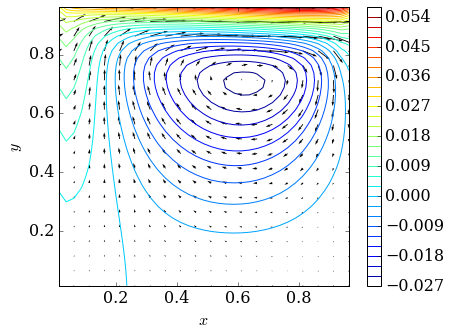

In [37]:
pyplot.figure(figsize=(6.5,5))
pyplot.contour(X[1:-2,1:-2],Y[1:-2,1:-2],psi1[1:-2,1:-2],30)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar()
pyplot.quiver(X[1:-2:2,1:-2:2],Y[1:-2:2,1:-2:2],u1[1:-2:2,1:-2:2],v1[1:-2:2,1:-2:2],scale=3)

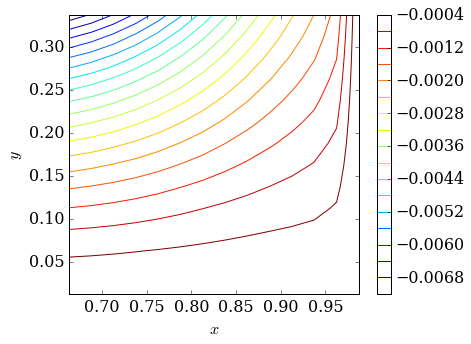

In [27]:
pyplot.figure(figsize=(6.5,5))
pyplot.contour(X[1:15,-15:-1],Y[1:15,-15:-1],psi1[1:15,-15:-1],20)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar()

In [58]:

ni=41
nj=41
dx=1./(ni-1)
dy=1./(nj-1)
x=numpy.linspace(-dx/2,1+dx/2,ni+1)
y=numpy.linspace(-dy/2,1+dy/2,nj+1)
xu=numpy.linspace(0,1+dx,ni+1)
yu=numpy.linspace(-dy/2,1+dy/2,nj+1)
xv=numpy.linspace(-dx/2,1+dx/2,ni+1)
yv=numpy.linspace(0,1+dy,nj+1)

X,Y=numpy.meshgrid(x,y)
Xu,Yu=numpy.meshgrid(xu,yu)
Xv,Yv=numpy.meshgrid(xv,yv)

u0=numpy.zeros((nj+1,ni+1))
v0=numpy.zeros((nj+1,ni+1))
u0[-1,1:-3]=2.
p0=numpy.zeros((nj+1,ni+1))
omega0=numpy.zeros((nj+1,ni+1))

u=u0.copy()
v=v0.copy()
p=p0.copy()
omega=omega0.copy()
G1=numpy.zeros((nj+1,ni+1))
G2=numpy.zeros((nj+1,ni+1))
w1=numpy.zeros((nj+1,ni+1))
w2=numpy.zeros((nj+1,ni+1)) 
f=numpy.zeros((nj+1,ni+1))
nt=0
dt=3e-4
uold=u.copy()
vold=v.copy()
pold=p.copy()
        
        #from t to t+dt/3
        #t+=dt/3
G1=Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
G2=Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
w1=u+dt/3*G1
w2=v+dt/3*G2


In [59]:
f[1:-1,1:-1]=3./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
p=poisson(f,1.9)
u,v=getuv(w1,w2,p,dx,dy,dt/3)

In [68]:
(w1[1:-1,1:-1]-w1[1:-1,:-2])


array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       ..., 
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.0064,  0.    ,  0.    , ...,  0.    , -0.0032,  0.    ]])

In [62]:
w2

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [60]:
p

array([[  7.60416153e+307,  -7.60416153e+307,              -inf, ...,
                      nan,               nan,               nan],
       [ -7.60416153e+307,   7.60416153e+307,               inf, ...,
                      nan,               nan,               nan],
       [              inf,              -inf,               nan, ...,
                      nan,               nan,               nan],
       ..., 
       [              nan,               nan,               nan, ...,
                      nan,               nan,               nan],
       [              nan,               nan,               nan, ...,
                      nan,               nan,               nan],
       [              nan,               nan,               nan, ...,
                      nan,               nan,               nan]])

ValueError: zero-size array to reduction operation minimum which has no identity

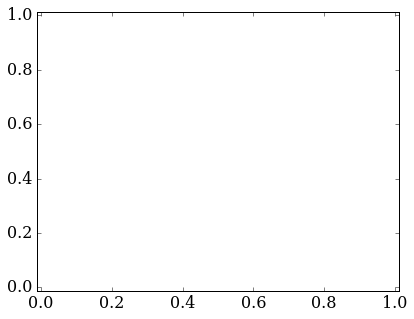

In [52]:
pyplot.figure(figsize=(6.5,5))
pyplot.contour(X,Y,G2,scale=13)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar()

In [ ]:
while nt<1000:
    uold=u.copy()
    vold=v.copy()
    pold=p.copy()
    G1=Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
    G2=Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
    w1=u+dt*G1
    w2=v+dt*G2
    f[1:-1,1:-1]=1./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
    p=poisson(f,1.85)
    u,v=getuv(w1,w2,p,dx,dy,dt)
    if nt%100==0:
        print(difference(u,uold))
    nt+=1

In [ ]:
psi=numpy.zeros((nj+1,ni+1))
for j in range(1,nj+1):
    for i in range(ni+1):
        psi[j,i]=psi[j-1,i]+u[j,i]*dy

In [ ]:
uold=u.copy()
vold=v.copy()
pold=p.copy()
G1=Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
G2=Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
w1=u+dt*G1
w2=v+dt*G2
f[1:-1,1:-1]=1./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)



In [ ]:
pyplot.figure(figsize=(6.5,5))
pyplot.contour(X,Y,psi,scale=13)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar()

In [ ]:
u[-2,:]+u[-1,:]

In [ ]:
p=poisson(f,1.85)
u,v=getuv(w1,w2,p,dx,dy,dt)
if nt%1==0:
    print(difference(u,uold))
nt+=1

In [ ]:
omega[1:,1:]=(v[1:,1:]-v[1:,:-1])/dx-(u[1:,1:]-u[:-1,1:])/dy

In [ ]:
pyplot.figure(figsize=(6.5,5))
pyplot.contour(X,Y,u,scale=13)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar()

In [ ]:
def grid_p(ni,nj):
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    x=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    y=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    X,Y=numpy.meshgrid(x,y)
    return X,Y

def grid_u(ni,nj):
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    xu=numpy.linspace(0,2*pi+dx,ni+1)
    yu=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    X,Y=numpy.meshgrid(xu,yu)
    return X,Y

def grid_v(ni,nj):
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    xv=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    yv=numpy.linspace(0,2*pi+dy,nj+1)
    X,Y=numpy.meshgrid(xv,yv)
    return X,Y

In [ ]:
@jit
def RK3(ni,nj,dt):
    T=2.
    nt=int(T/dt)
    t=0.
    dx=1./(ni-1)
    dy=1./(nj-1)
    x=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    y=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    xu=numpy.linspace(0,2*pi+dx,ni+1)
    yu=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    xv=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    yv=numpy.linspace(0,2*pi+dy,nj+1)

    X,Y=numpy.meshgrid(x,y)
    Xu,Yu=numpy.meshgrid(xu,yu)
    Xv,Yv=numpy.meshgrid(xv,yv)

    u0=numpy.zeros((nj+1,ni+1))
    v0=numpy.zeros((nj+1,ni+1))
    u0[-1,1:-3]=1.
    p0=numpy.zeros((nj+1,ni+1))
    omega0=numpy.zeros((nj+1,ni+1))

    u=u0.copy()
    v=v0.copy()
    p=p0.copy()
    omega=omega0.copy()
    res=numpy.zeros((nj+1,ni+1))
    nt=0
    
    while t<T:
        G1=numpy.zeros((nj+1,ni+1))
        G2=numpy.zeros((nj+1,ni+1))
        w1=numpy.zeros((nj+1,ni+1))
        w2=numpy.zeros((nj+1,ni+1)) 
        f=numpy.zeros((nj+1,ni+1))
        uold=u.copy()
        vold=v.copy()
        pold=p.copy()
        
        #from t to t+dt/3
        t+=dt/3
        G1=Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt/3*G1
        w2=v+dt/3*G2
        f[1:-1,1:-1]=3./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
        p=poisson(f,1.99)
        u,v=getuv(w1,w2,p,dx,dy,dt/3)
        
        #from t+dt/3 to t+3dt/4
        t+=5./12*dt
        G1=-5./9*G1+Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=-5./9*G2+Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt*15./16*G1
        w2=v+dt*15./16*G2
        f[1:-1,1:-1]=12./5/dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)        
        p=poisson(f,1.99)
        u,v=getuv(w1,w2,p,dx,dy,5.*dt/12)
        
        #from t+3dt/4 to t+dt
        t+=dt/4
        G1=-153./128*G1+Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=-153./128*G2+Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt*8./15*G1
        w2=v+dt*8./15*G2
        f[1:-1,1:-1]=4./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
        p=poisson(f,1.99)
        u,v=getuv(w1,w2,p,dx,dy,dt/4)
        
        if (nt)%200==0:
            print(difference(u,uold),difference(v,vold),difference(p,pold))
        nt+=1
    
    A=numpy.array([u,v,p])
    return A

In [ ]:
A1_1=RK3(21,21,3e-4)